### Protein Family Classification

In [204]:
%matplotlib inline

import pandas as pd
import numpy as np
import codecs
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_JAEV1,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [7]:
family_ids = family_classification_metadata['FamilyID'].value_counts()

In [167]:
def get_top_n_frequent_classes(n):
    return set(family_ids.index.values[:n])

In [65]:
NUM_CLASSES = 1000

classes = get_top_n_frequent_classes(NUM_CLASSES)
class_idx = {}

for i, cls in enumerate(classes):
    class_idx[cls] = i

In [89]:
prot_matrix = family_classification_sequences.as_matrix()
proteins = [prot_matrix[i][0] for i in range(prot_matrix.shape[0])]
del prot_matrix
max_prot_length = max([len(protein) for protein in proteins])
embed_length = embedding['AAA'].shape[0]

In [221]:
proteins_10K = []
y = []
for i, family in enumerate(family_classification_metadata['FamilyID']):
    if family in classes:
        proteins_10K.append(proteins[i])
        y.append(class_idx[family])

y = np.array(y)
DATASET_SIZE = y.shape[0]

proteins = proteins_10K

In [68]:
def read_data():
    prot_vec = pd.read_csv('./data/protVec_100d_3grams.csv', header=None, sep=r'\t|"').as_matrix()
    
    embedding = {}
    
    for i in range(prot_vec.shape[0]):
        line = prot_vec[i][1:-1]
        name = line[0]
        vector = line[1:]
        embedding[name] = vector
        
    return embedding

In [69]:
embedding = read_data()

/home/huckleberry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [253]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [254]:
from attrdict import AttrDict

BATCH_SIZE = 64
MAX_PROTEIN_LENGTH = 1000

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_PROTEIN_LENGTH,
    embed_length=embed_length
)

In [255]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/home/huckleberry/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [256]:
def protein_to_vector(protein):
    length = min(MAX_PROTEIN_LENGTH, len(protein) // 3)
    vector = np.zeros(shape=(length, embed_length))
    for j in range(0, length, 3):
        try:
            vector[j // 3] = embedding[protein[j: j + 3]]
        except KeyError:
            pass
    
    return vector

def convert_proteins_to_vectors(prots):
    vectors = np.zeros(shape=(len(prots), MAX_PROTEIN_LENGTH, embed_length))
    
    for i, protein in enumerate(prots):
        vector = protein_to_vector(protein)
        vectors[i, :vector.shape[0]] = vector

    return vectors

In [257]:
def generate_cross_entropy_mask(indices):
    return np.eye(NUM_CLASSES)[indices]

def generate_train_batch(idx):
    while True:
        indices = np.random.choice(idx, BATCH_SIZE)
        prots = convert_proteins_to_vectors([proteins[idx] for idx in indices])
        families = y[indices]
        yield prots, generate_cross_entropy_mask(families)
        
def generate_test_batch(idx):
    for i in range(0, len(idx), BATCH_SIZE):
        prots = convert_proteins_to_vectors(proteins[i: i + BATCH_SIZE])
        families = y[i: i + BATCH_SIZE]
        yield prots, generate_cross_entropy_mask(families)

In [258]:
from sklearn.model_selection import train_test_split

all_indices = np.array([i for i in range(family_ids.shape[0])])
idx_train, idx_test = train_test_split(all_indices, test_size=0.2)

In [259]:
ITERATIONS = 5000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    batch_generator = generate_train_batch(idx_train)
    for index, batch in enumerate(batch_generator):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        if index % 100 == 0:
            print('{}: {:3.1f}%'.format(index, 100 * error))
            summary_writer.add_summary(summary_str, index)
        if index >= ITERATIONS:
            break

    sum_error = 0
    counter = 0
    for batch in generate_test_batch(idx_test):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, summary_str = sess.run([model.error, model.summary], feed)
        sum_error += error
        counter += 1
        
    sum_error /= counter
    print("Error on test: " + str(sum_error))

0: 100.0%
100: 89.1%
200: 76.6%
300: 62.5%
400: 54.7%
500: 50.0%
600: 34.4%
700: 31.2%
800: 32.8%
900: 32.8%
1000: 26.6%
1100: 21.9%
1200: 23.4%
1300: 15.6%
1400: 29.7%
1500: 15.6%
1600: 17.2%
1700: 12.5%
1800: 7.8%
1900: 12.5%
2000: 12.5%
2100: 7.8%
2200: 0.0%
2300: 6.2%
2400: 9.4%
2500: 4.7%
2600: 7.8%
2700: 6.2%
2800: 7.8%
2900: 10.9%
3000: 10.9%
3100: 6.2%
3200: 7.8%
3300: 7.8%
3400: 10.9%
3500: 4.7%
3600: 6.2%
3700: 7.8%
3800: 4.7%
3900: 3.1%
4000: 7.8%
4100: 1.6%
4200: 9.4%
4300: 4.7%
4400: 4.7%
4500: 7.8%
4600: 3.1%
4700: 6.2%
4800: 6.2%
4900: 9.4%
5000: 6.2%
Error on test: 0.120738636364


In [260]:
two_frq_classes = get_top_n_frequent_classes(2)
two_frq_classes_idx = set(class_idx[cls] for cls in two_frq_classes)

two_frq_num_samples = sum(family_ids[:2].values)

two_frq_prot_embedding = np.zeros(
    shape=(two_frq_num_samples, MAX_PROTEIN_LENGTH * embed_length)
)

counter = 0
for i, protein in enumerate(proteins):
    if y[i] in two_frq_classes_idx:
        vector = protein_to_vector(protein)
        vector = vector.reshape((vector.shape[0] * embed_length))
        two_frq_prot_embedding[counter, :vector.shape[0]] = vector
        counter += 1

In [195]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
proteins_2d = tsne.fit_transform(two_frq_prot_embedding)

In [208]:
cls_2d = np.zeros(shape=(two_frq_num_samples))

two_frq_classes_idx = list(two_frq_classes_idx)

counter = 0
for i, protein in enumerate(proteins):
    if y[i] in two_frq_classes_idx:
        cls_2d[counter] = int(y[i] == two_frq_classes_idx[0])
        counter += 1

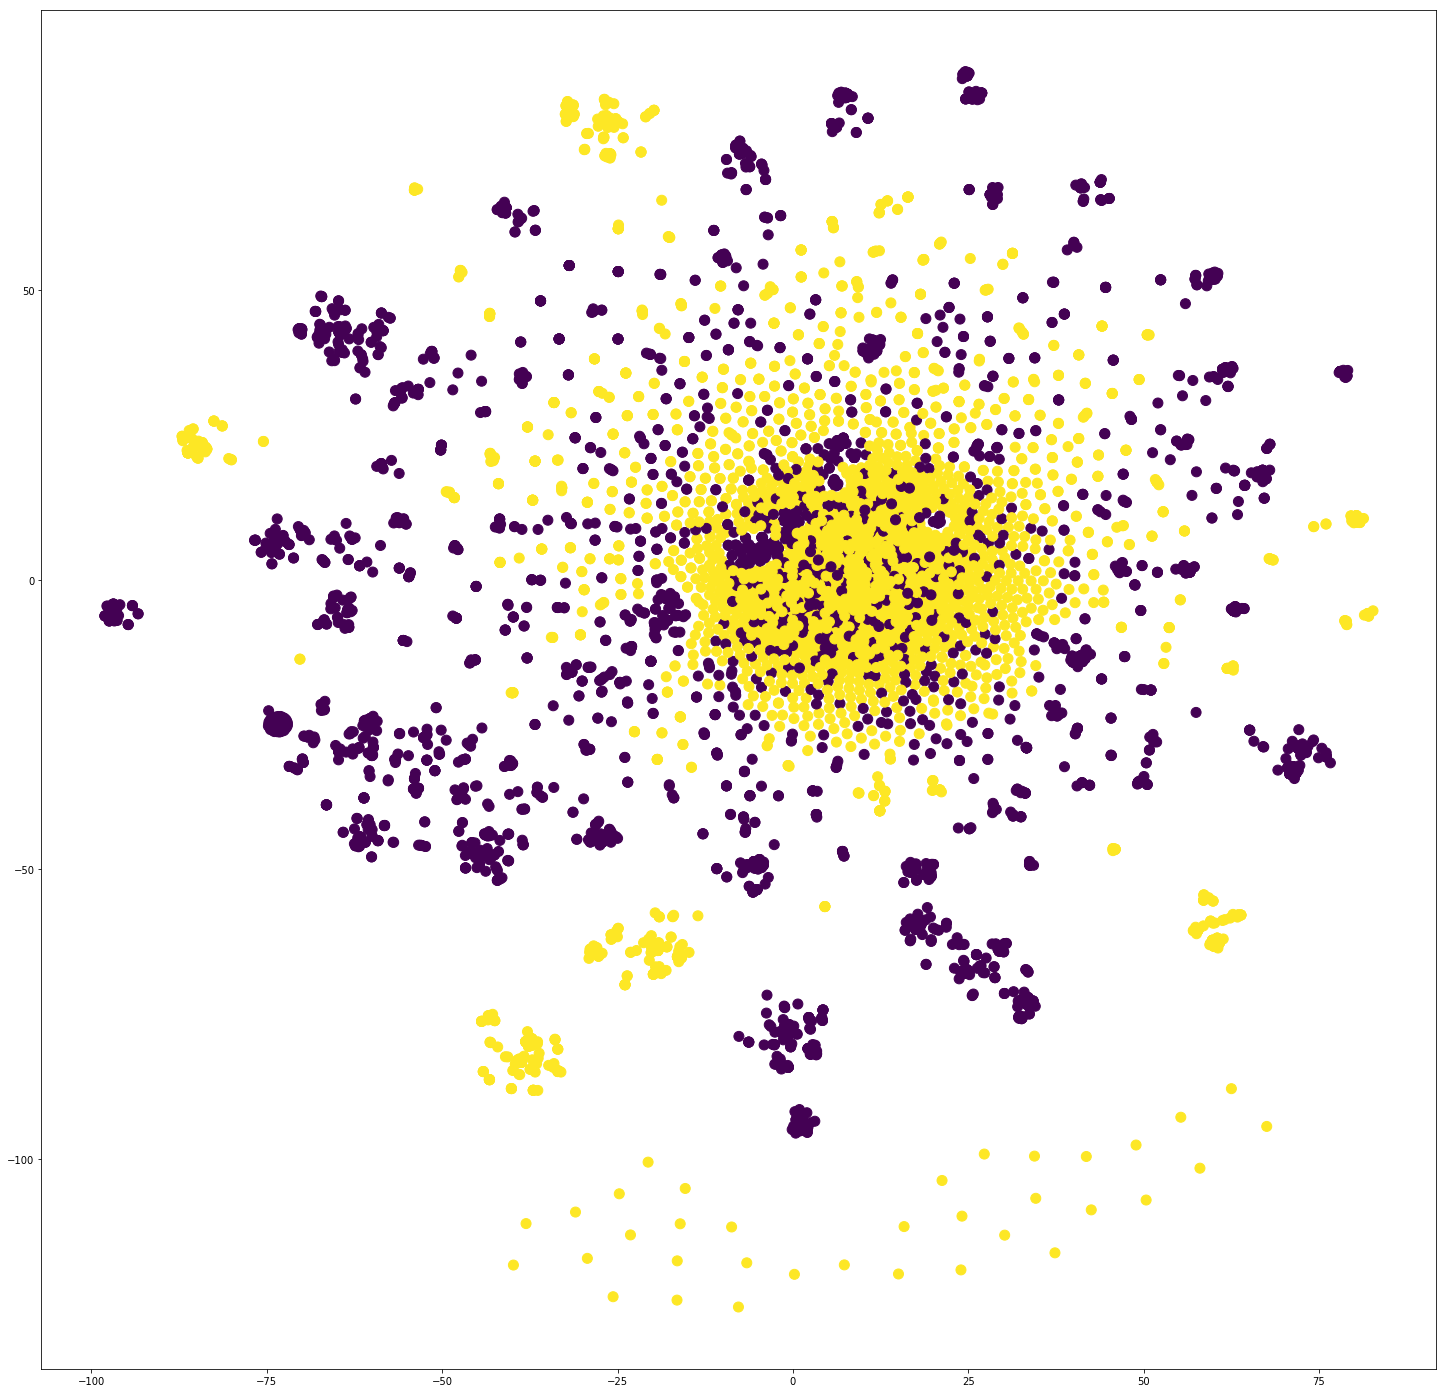

In [211]:
plt.figure(figsize=(25, 25))
plt.scatter(proteins_2d[:, 0], proteins_2d[:, 1], c=cls_2d, s=100)

In [261]:
class MLP:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self._create_optimizer()
        self.prediction
        self.cost
        self.error
        
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.input_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES])
    
    @lazy
    def prediction(self):
        with tf.name_scope("fc_layer"):
            weight = tf.Variable(tf.truncated_normal(
                [self.params.input_length, self.params.num_hidden], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[self.params.num_hidden]))
            output = tf.tanh(tf.matmul(self.data, weight) + bias)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.num_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(output, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    def _create_optimizer(self):
        self.optimizer = tf.train.RMSPropOptimizer(0.002).minimize(self.cost)

In [262]:
from attrdict import AttrDict

BATCH_SIZE = 64
MAX_PROTEIN_LENGTH = 1000

mlp_params = AttrDict(
    num_hidden=256,
    batch_size=BATCH_SIZE,
    input_length=MAX_PROTEIN_LENGTH * embed_length
)

tf.reset_default_graph()
mlp = MLP(mlp_params)

In [263]:
ITERATIONS = 5000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    batch_generator = generate_train_batch(idx_train)
    for index, batch in enumerate(batch_generator):
        feed = {mlp.data: batch[0].reshape(BATCH_SIZE, MAX_PROTEIN_LENGTH * embed_length), mlp.target: batch[1]}
        error, _ = sess.run([mlp.error, mlp.optimizer], feed)
        if index % 100 == 0:
            print('{}: {:3.1f}%'.format(index, 100 * error))
        if index >= ITERATIONS:
            break

    sum_error = 0
    counter = 0
    for batch in generate_test_batch(idx_test):
        feed = {mlp.data: batch[0].reshape(BATCH_SIZE, MAX_PROTEIN_LENGTH * embed_length), mlp.target: batch[1]}
        error = sess.run(mlp.error, feed)
        sum_error += error
        counter += 1
        
    sum_error /= counter
    print("Error on test: " + str(sum_error))

0: 100.0%
100: 48.4%
200: 20.3%
300: 9.4%
400: 9.4%
500: 7.8%
600: 1.6%
700: 4.7%
800: 7.8%
900: 6.2%
1000: 0.0%
1100: 1.6%
1200: 7.8%
1300: 6.2%
1400: 7.8%
1500: 3.1%
1600: 12.5%
1700: 6.2%
1800: 9.4%
1900: 7.8%
2000: 10.9%
2100: 9.4%
2200: 3.1%
2300: 9.4%
2400: 10.9%
2500: 4.7%
2600: 7.8%
2700: 4.7%
2800: 9.4%
2900: 1.6%
3000: 6.2%
3100: 12.5%
3200: 6.2%
3300: 9.4%
3400: 4.7%
3500: 3.1%
3600: 3.1%
3700: 4.7%
3800: 1.6%
3900: 1.6%
4000: 9.4%
4100: 9.4%
4200: 7.8%
4300: 12.5%
4400: 3.1%
4500: 9.4%
4600: 6.2%
4700: 7.8%
4800: 7.8%
4900: 7.8%
5000: 3.1%
Error on test: 0.113636363636
